If additional cations are included, they may be included as (screened) Coulomb interactions with additional LJ/Buckingham potentials.
ref: https://pubs.rsc.org/en/Content/ArticleLanding/2011/CP/c1cp21034c

Solubility of CO2 is approximately 1g/kg H2O at 300 K, so there is approximately 2500 water molecules per molecule of CO2.

In [1]:
%pylab notebook
%load_ext autoreload
%autoreload 2

from mpl_toolkits.mplot3d import Axes3D
import scipy.constants as cst
from lammpsrun import LAMMPS, Prism
from itertools import product

from ase import Atoms, units
from ase.visualize import view
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.neighborlist import neighbor_list
from ase.build import *
from ase.md import *

homepath = "D:\\Cloud Storage\\GitRepositories\\LAMMPS_Simulation\\"
homepath

Populating the interactive namespace from numpy and matplotlib


'D:\\Cloud Storage\\GitRepositories\\LAMMPS_Simulation\\'

# Equilibriating the H2O box

In [2]:
H2O_bulk = molecule('H2O')

box_length = ((125 / (55.5 * cst.Avogadro)) * (1e+27))**(1 / 3)

H2O_bulk.set_cell((box_length, box_length, box_length))
H2O_bulk.center()

H2O_bulk = H2O_bulk.repeat((5, 5, 5))
H2O_bulk.rattle(stdev=0.01)
H2O_bulk.set_pbc(True)

view(H2O_bulk, viewer='ngl')

In [3]:
# H2O configuration ref: http://www.wag.caltech.edu/home/duin/Reax/ReaxFF_HCO_JPCA.pdf
H2O_bulk_reaxff_params = {
    # Initialization
    "units": "real",
    "atom_style": "charge",
    "mass": ["1 1.008",
             "2 15.999"],
    "velocity": ["all create 300.0 4928459 rot yes dist gaussian"],
    
    # Forcefield definition
    "pair_style": "reax/c NULL safezone 16",
    "pair_coeff": ['* * ' + 'ffield.reax.oh' + ' H O'],
    "neighbor": "2.0 bin",
    #"neighbor_modify": "delay 10 check yes",
    
    # Run and Minimization
    "run": "1000",
    "timestep": 0.5,
    "fix": ["1 all nve",
            "2 all qeq/reax 1 0.0 10.0 1e-6 reax/c"]#,
            #"2 all temp/berendsen 300.0 300.0 100"]
}

In [4]:
# Setting up simulation input
H2O_bulk_calc = LAMMPS(tmp_dir = homepath + "temp", 
                       parameters = H2O_bulk_reaxff_params,
                       keep_tmp_files=True, no_data_file=True)
H2O_bulk.set_calculator(H2O_bulk_calc)
H2O_bulk_calc.atoms = H2O_bulk.copy()
H2O_bulk_calc.prism = Prism(H2O_bulk_calc.atoms.get_cell())

In [17]:
# Writing input file
H2O_bulk_calc.write_lammps_in(lammps_in = homepath + "co2_hydration\\H2O_bulk_reaxff.in",
                              lammps_trj = homepath + "co2_hydration\\H2O_bulk_reaxff.lammpstrj")

In [11]:
# Running calculations
!lmp_serial -in co2_hydration\H2O_bulk_reaxff.in -log co2_hydration\H2O_bulk_reaxff.log

LAMMPS (16 Aug 2018)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:87)
  using 1 OpenMP thread(s) per MPI task
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:87)
  using 1 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 1 1 1
Created orthogonal box = (0 0 0) to (77.6114 77.6114 77.6114)
  1 by 1 by 1 MPI processor grid
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0.000495911 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent 

     890    282.43785    12.653754    4.6013899     26.53669     -4.68642    16.110991   -2.7926423   -9.9186925   -6.4275059     314.8682   -31456.201   -31141.332     467494.1    77.611375    77.611375    77.611375      375 
     891    286.32497    28.307719    4.6068449    34.318939    17.246506    33.357714   -1.6622296    -15.70235   -10.056135    319.20165   -31460.682    -31141.48     467494.1    77.611375    77.611375    77.611375      375 
     892    286.39492    42.698983    4.6137929    40.372783    37.137703    50.586462   0.15701243   -20.043861   -13.482539    319.27963   -31460.727   -31141.447     467494.1    77.611375    77.611375    77.611375      375 
     893    283.22261    53.871817     4.618751    41.502083    56.140311    63.973058    2.4408136   -20.661392   -15.789803    315.74306   -31457.155   -31141.412     467494.1    77.611375    77.611375    77.611375      375 
     894    277.99778     62.06442     4.623214    38.908239    74.903909    72.381111    5.

In [12]:
# Reading LAMMPS output
H2O_bulk_calc.read_lammps_log(lammps_log = homepath + "co2_hydration\\H2O_bulk_reaxff.log")
H2O_bulk_data = H2O_bulk_calc.thermo_content[-1]

H2O_bulk_calc.trajectory_out = Trajectory(homepath + "co2_hydration\\H2O_bulk_reaxff.traj", 'w')
H2O_bulk_calc.read_lammps_trj(lammps_trj = homepath + "co2_hydration\\H2O_bulk_reaxff.lammpstrj")
H2O_bulk_calc.trajectory_out.close()

## Visualizing LAMMPS trajectory

In [63]:
#H2O_bulk_traj = Trajectory("G:\\home\\LAMMPS_Simulation\\co2_hydration\\H2O_bulk_reaxff.traj")
H2O_bulk_traj = Trajectory(homepath + "co2_hydration\\H2O_bulk_reaxff.traj", 'r')

H2O_bulk_traj_view = view(H2O_bulk_traj, viewer='ngl')
H2O_bulk_traj_view.view.update_spacefill(radiusType='covalent',
                                         scale=0.8,
                                         color_scheme='element',
                                         color_scale='rainbow')
H2O_bulk_traj_view.view.player.step = 10
H2O_bulk_traj_view

In [43]:
H2O_bulk_traj_pos = []

for i in range(0, 1000, 10):
    O_atoms = H2O_bulk_traj[i][[a.index for a in H2O_bulk_traj[i] if a.symbol == 'O']]
    O_pos = O_atoms.positions
    H2O_bulk_traj_pos.append(O_pos)
    
H2O_bulk_traj_pos = array(H2O_bulk_traj_pos)
H2O_bulk_traj_pos_plot = H2O_bulk_traj_pos.transpose(1, 2, 0)

<IPython.core.display.Javascript object>


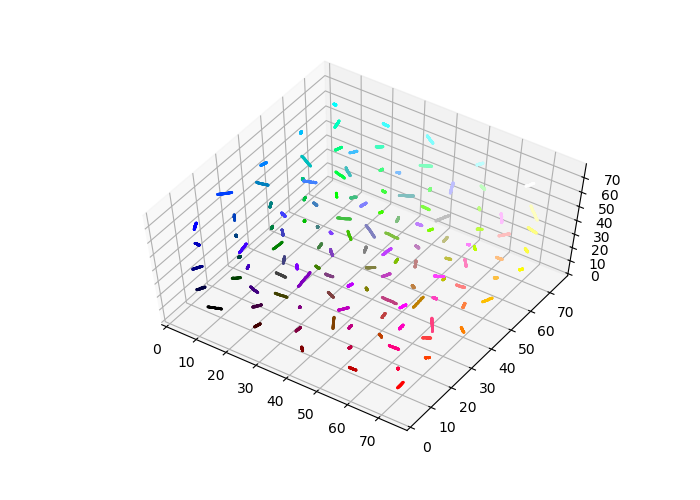

In [18]:
# Plotting individual atom as points

fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(111, projection='3d')

C = linspace(0, 255, 5)
C_list = array([list(x) for x in product(C, C, C)])/255

#ax.set_xlabel('Box x-axis')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
ax.set_xlim(0, box_length*5)
ax.set_ylim(0, box_length*5)
ax.set_zlim(0, box_length*5)

for img in H2O_bulk_traj_pos:
    ax.scatter(img[:,0], img[:,1], img[:,2], c=C_list, s=1)
    
plt.show()

<IPython.core.display.Javascript object>


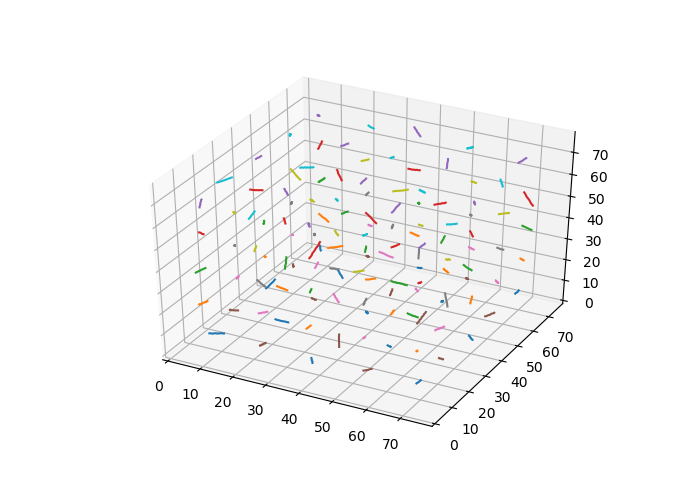

In [19]:
# Plotting individual atoms as lines. The lines crosses the whole simulation box when the particle
# crosses the PBs, not ideal.

fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(111, projection='3d')

#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
ax.set_xlim(0, box_length*5)
ax.set_ylim(0, box_length*5)
ax.set_zlim(0, box_length*5)

for a in H2O_bulk_traj_pos_plot:
    ax.plot(a[0], a[1], a[2])

plt.show()

# Creating CO2 bulk box

In [8]:
CO2_bulk = molecule('CO2')

box_length = ((125 / (55.5 * cst.Avogadro)) * (1e+27))**(1 / 3)

CO2_bulk.set_cell((box_length, box_length, box_length))
CO2_bulk.center()

CO2_bulk = CO2_bulk.repeat((5, 5, 5))
CO2_bulk.rattle(stdev=0.01)
CO2_bulk.set_pbc(True)

view(CO2_bulk, viewer='ngl')

In [35]:
CO2_bulk_reaxff_params = {
    # Initialization
    "units": "real",
    "atom_style": "charge",
    "mass": ["1 12.011",
             "2 15.999"],
    "velocity": ["all create 300.0 4928459 rot yes dist gaussian"],
    
    # Forcefield definition
    "pair_style": "reax/c NULL safezone 16",
    #"pair_coeff": ['* * ' + 'ffield.reax.P_Na_Si_S_N_O_H_C' + ' C O'],
    "pair_coeff": ['* * ' + 'ffield.reax.Fe_O_C_H' + ' C O'],
    "neighbor": "2.0 bin",
    #"neighbor_modify": "delay 10 check yes",
    
    # Run and Minimization
    "run": "10000",
    "timestep": 0.5,
    "fix": ["1 all nve",
            "2 all qeq/reax 1 0.0 10.0 1e-6 reax/c"]#,
            #"2 all temp/berendsen 300.0 300.0 100"]
}

In [36]:
# Setting up simulation input
CO2_bulk_calc = LAMMPS(parameters = CO2_bulk_reaxff_params,
                       keep_tmp_files=False, no_data_file=True)

CO2_bulk.set_calculator(CO2_bulk_calc)
CO2_bulk_calc.atoms = CO2_bulk.copy()
CO2_bulk_calc.prism = Prism(CO2_bulk_calc.atoms.get_cell())

In [37]:
# Writing input file
CO2_bulk_calc.write_lammps_in(lammps_in = homepath + "co2_hydration\\CO2_bulk_reaxff.in",
                              lammps_trj = homepath + "co2_hydration\\CO2_bulk_reaxff.lammpstrj")

In [38]:
# Running calculations
!lmp_serial -in co2_hydration\CO2_bulk_reaxff.in -log co2_hydration\CO2_bulk_reaxff.log

LAMMPS (16 Aug 2018)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:87)
  using 1 OpenMP thread(s) per MPI task
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:87)
  using 1 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 1 1 1
Created orthogonal box = (0 0 0) to (77.6114 77.6114 77.6114)
  1 by 1 by 1 MPI processor grid
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
C

     719    6482.1884    1186.5798     3.403594    1164.6299    109.94203    2285.1674    488.54623   -152.15153    283.71043    7226.4924   -26801.627   -19575.134     467494.1    77.611375    77.611375    77.611375      375 
     720    6525.6449     624.6356     3.409548    352.75948   -126.23735    1647.3847    417.27443   -35.171511    26.982808    7274.9387   -26885.899    -19610.96     467494.1    77.611375    77.611375    77.611375      375 
     721    6539.1456    182.05695      3.41401    541.39305   -488.97327    493.75107    54.606286   -201.59966    93.310993    7289.9896   -26857.017   -19567.028     467494.1    77.611375    77.611375    77.611375      375 
     722    6448.0919   -335.35544      3.41798    366.96409   -861.55094   -511.47949   -206.60508   -282.32326    495.23596    7188.4809   -26746.633   -19558.152     467494.1    77.611375    77.611375    77.611375      375 
     723    6262.3325   -216.77302      3.42294    529.17149    -649.0301   -530.46045    -1

    2218    6905.9678    480.15871     9.946763     894.4404    270.79716    275.23857    90.856604    400.32058    140.74397    7698.9315   -22458.564   -14759.632     467494.1    77.611375    77.611375    77.611375      375 
    2219    6684.8734    203.65955    9.9512219    253.02465    102.96235    254.99166   -45.670312   -58.565865    41.880059    7452.4504   -22184.787   -14732.336     467494.1    77.611375    77.611375    77.611375      375 
    2220    6642.5465     159.3764    9.9556859    -185.2677    159.58701    503.80989   -70.125353   -106.67233     277.4735    7405.2633   -22143.282   -14738.018     467494.1    77.611375    77.611375    77.611375      375 
    2221    6861.0596    473.62822      9.96015     21.16152     434.1718    965.55134   -141.04637   -187.14901     474.8381    7648.8667   -22399.995   -14751.128     467494.1    77.611375    77.611375    77.611375      375 
    2222    7091.9953    498.92297     9.964118    335.96093    366.14137     794.6666   -30

    3218    7727.1471    487.82829    14.889852    297.16207    43.294579    1123.0282   -413.96392   -68.428259   -143.98933     8614.401   -22227.255   -13612.854     467494.1    77.611375    77.611375    77.611375      375 
    3219    7810.2383    296.84617    14.894317   -119.03647   -68.001128    1077.5761   -337.48018    86.690992   -291.82041    8707.0329   -22358.482   -13651.449     467494.1    77.611375    77.611375    77.611375      375 
    3220    7752.9755    104.63045    14.898284    -236.9207   -42.960434     593.7725    87.173489    105.46817   -144.22472    8643.1951   -22265.153   -13621.958     467494.1    77.611375    77.611375    77.611375      375 
    3221    7727.4018    144.66012    14.902253     4.794412    186.80071    242.38523    127.71044    90.453713   -51.202318     8614.685   -22225.559   -13610.874     467494.1    77.611375    77.611375    77.611375      375 
    3222    7725.2842    657.63117    14.905724    592.18832    416.53269    964.17249    19

    4717    7977.6546    572.40808    21.572956    433.43509    444.50624    839.28291    506.82342    72.161184   -262.72727    8893.6726   -19991.164   -11097.491     467494.1    77.611375    77.611375    77.611375      375 
    4718     7990.662    597.61606    21.576923    277.47266    383.57491    1131.8006     427.6019    150.63348   -242.82249    8908.1735   -20053.489   -11145.315     467494.1    77.611375    77.611375    77.611375      375 
    4719    7842.1728    562.76791    21.581387    258.76505    195.00429    1234.5344    178.99529    195.74771    89.166698    8742.6342    -19855.14   -11112.506     467494.1    77.611375    77.611375    77.611375      375 
    4720    7670.2177    761.01627    21.584859     650.3725    339.64281    1293.0335    94.286654   -69.785565    153.43208    8550.9348   -19645.495   -11094.561     467494.1    77.611375    77.611375    77.611375      375 
    4721    7605.3227     679.8737    21.588827    847.72179    387.76417    804.13513   -84

    6217    8046.7944    734.82568    27.773206    993.98697    367.85769    842.63239    70.168233    351.62115   -374.06783    8970.7512   -18846.843   -9876.0922     467494.1    77.611375    77.611375    77.611375      375 
    6218    7921.5748    885.40157    27.778167     1267.458    249.42693    1139.3198    -152.7469    170.73355   -322.21573    8831.1534   -18675.602   -9844.4482     467494.1    77.611375    77.611375    77.611375      375 
    6219    7790.0448    945.81381    27.782135    1202.1582    379.99733    1255.2859   -310.29983    189.24223   -170.44916    8684.5208   -18521.984   -9837.4635     467494.1    77.611375    77.611375    77.611375      375 
    6220    7729.0594      553.346    27.787053    405.36718    276.97449    977.69633    -322.6157    122.63004    112.09862    8616.5329   -18462.207   -9845.6741     467494.1    77.611375    77.611375    77.611375      375 
    6221    7726.2902    428.25473    27.792015     183.6428    169.47204    931.64934   -30

    7716    7871.6412    1126.2921    34.812894     1252.204    1146.7712     979.9011    -38.01174   -90.186181    137.29469    8775.4863   -17368.995   -8593.5085     467494.1    77.611375    77.611375    77.611375      375 
    7717    7856.5467    1365.9089    34.816365    1354.0443    1611.8176    1131.8649    40.497968   -21.537481    82.484501    8758.6586    -17355.29   -8596.6318     467494.1    77.611375    77.611375    77.611375      375 
    7718    7948.5299    1179.7922    34.819838     1131.681    1454.9307    952.76502   -36.571977   -100.18588    58.769605    8861.2037   -17442.473    -8581.269     467494.1    77.611375    77.611375    77.611375      375 
    7719    8099.8586     746.0396    34.823806    533.77805    1003.3486    700.99218   -139.90017   -176.00456   -39.568534    9029.9084   -17628.602   -8598.6936     467494.1    77.611375    77.611375    77.611375      375 
    7720    8183.9258    359.84871    34.827774    280.86693    307.66881    491.01039   -16

    9216    8595.8875    126.09196    41.341245   -186.85915    518.00197    47.133061    299.16799    194.67369   -149.09026    9582.8927   -17242.568   -7659.6753     467494.1    77.611375    77.611375    77.611375      375 
    9217    8486.9182    205.60333     41.34476    55.563078    365.91211    195.33482    417.74889    46.919785   -16.791158    9461.4113   -17107.874   -7646.4631     467494.1    77.611375    77.611375    77.611375      375 
    9218    8335.0193    576.73063    41.348727    532.14057    506.26981    691.78153    204.02324    18.468885   -35.605225    9292.0709   -16954.661   -7662.5901     467494.1    77.611375    77.611375    77.611375      375 
    9219    8230.4989    986.06227      41.3527    918.83092    797.03035    1242.3255    56.085816    28.760048    14.842164    9175.5492   -16828.754   -7653.2053     467494.1    77.611375    77.611375    77.611375      375 
    9220     8223.051    1287.1125    41.357165    1140.5899    1118.4665    1602.2813    48

    9715    8635.6232    835.03401    43.371416    616.51444    688.51081    1200.0768    47.552835    224.11269    -105.0464     9627.191    -16697.39   -7070.1988     467494.1    77.611375    77.611375    77.611375      375 
    9716    8649.5467    1095.8509    43.377327    686.70702    1146.5392    1454.3064    -28.04095    151.84413   -3.1381149    9642.7133   -16746.879   -7104.1655     467494.1    77.611375    77.611375    77.611375      375 
    9717     8524.964    897.35178    43.384269    358.06776    924.40866    1409.5789   -142.08266    132.97505    60.614325    9503.8256   -16591.307   -7087.4818     467494.1    77.611375    77.611375    77.611375      375 
    9718    8432.9423     732.3884    43.392702    363.83866    781.00554     1052.321   -189.72737    97.477145   -79.530231    9401.2376   -16493.921   -7092.6834     467494.1    77.611375    77.611375    77.611375      375 
    9719    8502.2555    744.55684    43.396174     613.2193    803.83537    816.61585   -29

In [39]:
# Reading LAMMPS output
CO2_bulk_calc.read_lammps_log(lammps_log = homepath + "co2_hydration\\CO2_bulk_reaxff.log")
CO2_bulk_data = CO2_bulk_calc.thermo_content[-1]

CO2_bulk_calc.trajectory_out = Trajectory(homepath + "co2_hydration\\CO2_bulk_reaxff.traj", 'w')
CO2_bulk_calc.read_lammps_trj(lammps_trj = homepath + "co2_hydration\\CO2_bulk_reaxff.lammpstrj")
CO2_bulk_calc.trajectory_out.close()

In [51]:
#CO2_solvation_traj = Trajectory("G:\\home\\LAMMPS_Simulation\\co2_hydration\\CO2_solvation_reaxff.traj")
CO2_bulk_traj = Trajectory(homepath + "co2_hydration\\CO2_bulk_reaxff.traj", 'r')

CO2_bulk_traj_view = view(CO2_bulk_traj, viewer='ngl')
CO2_bulk_traj_view.view.update_spacefill(radiusType='covalent',
                                         scale=0.8,
                                         color_scheme='element',
                                         color_scale='rainbow')
CO2_bulk_traj_view.view.player.step = 1
CO2_bulk_traj_view.view.player.delay = 1000/24 #24fps

CO2_bulk_traj_view

# Creating CO2 solvation box

In [44]:
CO2_solvation = H2O_bulk_traj[-1].copy()

We are removing a random unit of H2O molecule from the last frame of the equilibriation and replacing it with CO2.

In [47]:
n_remove = randint(0,374)
i,j = neighbor_list('ij', CO2_solvation, 1.8, self_interaction=True)
index_remove = j[i == n_remove]

In [48]:
new_molecule = molecule('CO2')
new_molecule.set_positions(new_molecule.get_positions() + CO2_solvation[index_remove].get_positions()[0,:])

In [49]:
del CO2_solvation[index_remove]

In [50]:
CO2_solvation += new_molecule
CO2_solvation.pbc = True

In [67]:
write("CO2_solvation.extxyz", CO2_solvation, format = "extxyz")

In [73]:
view(CO2_solvation, viewer='ngl')

In [57]:
CO2_solvation_reaxff_params = {
    # Initialization
    "units": "real",
    "atom_style": "charge",
    "mass": ["1 12.011",
             "2 1.008",
             "3 15.999"],
    "velocity": ["all create 300.0 4928459 rot yes dist gaussian"],
    
    # Forcefield definition
    "pair_style": "reax/c NULL safezone 16",
    "pair_coeff": ['* * ' + 'ffield.reax.P_Na_Si_S_N_O_H_C' + ' C H O'],
    "neighbor": "2.0 bin",
    #"neighbor_modify": "delay 10 check yes",
    
    # Run and Minimization
    "run": "1000",
    "timestep": 0.5,
    "fix": ["1 all nve",
            "2 all qeq/reax 1 0.0 10.0 1e-6 reax/c"]#,
            #"2 all temp/berendsen 300.0 300.0 100"]
}

In [58]:
# Setting up simulation input
CO2_solvation_calc = LAMMPS(parameters = CO2_solvation_reaxff_params,
                            keep_tmp_files=False, no_data_file=True)

CO2_solvation.set_calculator(CO2_solvation_calc)
CO2_solvation_calc.atoms = CO2_solvation.copy()
CO2_solvation_calc.prism = Prism(CO2_solvation_calc.atoms.get_cell())

In [59]:
# Writing input file
CO2_solvation_calc.write_lammps_in(lammps_in = homepath + "co2_hydration\\CO2_solvation_reaxff.in",
                                   lammps_trj = homepath + "co2_hydration\\CO2_solvation_reaxff.lammpstrj")

In [60]:
# Running calculations
!lmp_serial -in co2_hydration\CO2_solvation_reaxff.in -log co2_hydration\CO2_solvation_reaxff.log

LAMMPS (16 Aug 2018)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:87)
  using 1 OpenMP thread(s) per MPI task
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:87)
  using 1 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 1 1 1
Created orthogonal box = (0 0 0) to (77.6114 77.6114 77.6114)
  1 by 1 by 1 MPI processor grid
Created 1 atoms
  Time spent = 0.000452042 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent 

In [61]:
# Reading LAMMPS output
CO2_solvation_calc.read_lammps_log(lammps_log = homepath + "co2_hydration\\CO2_solvation_reaxff.log")
CO2_solvation_data = CO2_solvation_calc.thermo_content[-1]

CO2_solvation_calc.trajectory_out = Trajectory(homepath + "co2_hydration\\CO2_solvation_reaxff.traj", 'w')
CO2_solvation_calc.read_lammps_trj(lammps_trj = homepath + "co2_hydration\\CO2_solvation_reaxff.lammpstrj")
CO2_solvation_calc.trajectory_out.close()

In [62]:
#CO2_solvation_traj = Trajectory("G:\\home\\LAMMPS_Simulation\\co2_hydration\\CO2_solvation_reaxff.traj")
CO2_solvation_traj = Trajectory(homepath + "co2_hydration\\CO2_solvation_reaxff.traj", 'r')

CO2_solvation_traj_view = view(CO2_solvation_traj, viewer='ngl')
CO2_solvation_traj_view.view.update_spacefill(radiusType='covalent',
                                              scale=0.8,
                                              color_scheme='element',
                                              color_scale='rainbow')
CO2_solvation_traj_view.view.player.step = 10
CO2_solvation_traj_view